<a href="https://colab.research.google.com/github/SD325/NASA_Internship_2020/blob/master/NASA_End_to_End_Multi_Day_Random_Forest_FIXED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Imports
import joblib
import pickle
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix


# Working Directory 
BASE_DIR = '/content/drive/My Drive/data/NASA_2020/'

# Prepare Data

## Read Data

In [3]:
import scipy.io
BASE_DIR = '/content/drive/My Drive/data/NASA_2020/'
# fall, winter, spring, summer
filenames =['colloc_Precipflag_DPR_GMI_20151007.sav',
            'colloc_Precipflag_DPR_GMI_20160113.sav',
            'colloc_Precipflag_DPR_GMI_20160401.sav']
            #,'colloc_Precipflag_DPR_GMI_20170606.sav']
FILE_PATHS = [BASE_DIR + fn for fn in filenames]
data = [scipy.io.readsav(filepath, verbose=1) for filepath in FILE_PATHS]

--------------------------------------------------
Date: Sat Jun 27 00:49:52 2020
User: jgong
Host: gs613-cirrus.ndc.nasa.gov
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.7.3
--------------------------------------------------
Successfully read 14 records of which:
 - 11 are of type VARIABLE
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - tc [<class 'numpy.ndarray'>]
 - latc [<class 'numpy.ndarray'>]
 - lonc [<class 'numpy.ndarray'>]
 - utc [<class 'numpy.ndarray'>]
 - emis [<class 'numpy.ndarray'>]
 - emis_std [<class 'numpy.ndarray'>]
 - ts [<class 'numpy.ndarray'>]
 - clwp [<class 'numpy.ndarray'>]
 - twv [<class 'numpy.ndarray'>]
 - tysfc [<class 'numpy.ndarray'>]
 - pflag [<class 'numpy.ndarray'>]
--------------------------------------------------
--------------------------------------------------
Date: Fri Jun 26 15:53:36 2020


## Trim Data

In [4]:
import copy
data_trimmed = []
for i, data_i in enumerate(data):
  data_trimmed_i = {}
  for var, arr in data_i.items():
    if arr.ndim == 1:
      data_trimmed_i[var] = arr[1:] 
    else:
      data_trimmed_i[var] = arr[1:, 25:196] if arr.ndim == 2 else arr[1:, 25:196, :] 

  for var, arr in data_trimmed_i.items():
    print(f"{var}: {arr.shape}")
  print('-' * 15)
  data_trimmed.append(data_trimmed_i)

# free up memory
del data

tc: (47380, 171, 13)
latc: (47380, 171)
lonc: (47380, 171)
utc: (47380,)
emis: (47380, 171, 13)
emis_std: (47380, 171, 13)
ts: (47380, 171)
clwp: (47380, 171)
twv: (47380, 171)
tysfc: (47380, 171)
pflag: (47380, 171)
---------------
tc: (47370, 171, 13)
latc: (47370, 171)
lonc: (47370, 171)
utc: (47370,)
emis: (47370, 171, 13)
emis_std: (47370, 171, 13)
ts: (47370, 171)
clwp: (47370, 171)
twv: (47370, 171)
tysfc: (47370, 171)
pflag: (47370, 171)
---------------
tc: (47407, 171, 13)
latc: (47407, 171)
lonc: (47407, 171)
utc: (47407,)
emis: (47407, 171, 13)
emis_std: (47407, 171, 13)
ts: (47407, 171)
clwp: (47407, 171)
twv: (47407, 171)
tysfc: (47407, 171)
pflag: (47407, 171)
---------------


## Polarization Differences (PDs)

In [5]:
# calculate polarization differences (PD)
def add_to_PD_i(i, freq, ind1, ind2, data):
  PD[i][freq] = data[i]['tc'][:, :, ind1] - data[i]['tc'][:, :, ind2]

PD = [{} for _ in range(len(data_trimmed))]
for i in range(len(data_trimmed)):
  add_to_PD_i(i, '10.65', 0, 1, data_trimmed)
  add_to_PD_i(i, '18.70', 2, 3, data_trimmed)
  add_to_PD_i(i, '36.50', 5, 6, data_trimmed)
  add_to_PD_i(i, '89.00', 7, 8, data_trimmed)
  add_to_PD_i(i, '166.0', 9, 10, data_trimmed)
  print(PD[i].keys())

dict_keys(['10.65', '18.70', '36.50', '89.00', '166.0'])
dict_keys(['10.65', '18.70', '36.50', '89.00', '166.0'])
dict_keys(['10.65', '18.70', '36.50', '89.00', '166.0'])


## Construct DataFrame

In [6]:
# ravel 2d data --> scans one after another
'''
* 13 channels TB
* 3 channels PD (10.65, 89 and 166 GHz)
x Surface emissivity
* Ts
* CLWP
* TWV
* Lat/Lon
- Day of the year starting from the first day of the year (i.e., Julian day. For example, 1/1/2017 is 1, 2/1/2017 is 32)
'''
data_dfs = []

PD_freqs_append = ['10.65', '89.00', '166.0']
data_2d = {'latc': 'lat',
           'lonc': 'lon',
           'ts': 'ts',
           'clwp': 'clwp',
           'twv': 'twv'}
for i, data_i in enumerate(data_trimmed):
  curr_df = pd.DataFrame()
  # 2d data
  for data_name, df_name in data_2d.items():
    curr_df[df_name] = np.ravel(data_i[data_name])

  # PDs
  for freq in PD_freqs_append:
    curr_df[f'PD_{freq}'] = np.ravel(PD[i][freq])

  # 3d data
  for idx in range(data_i['tc'].shape[2]):
    curr_df[f'tc_{idx}'] = np.ravel(data_i['tc'][:, :, idx])

  data_dfs.append(curr_df)
  del curr_df

print('combining DataFrames')
data_df = pd.concat(data_dfs, ignore_index = True)
del data_dfs
data_df.head()

combining DataFrames


,lat,lon,ts,clwp,twv,PD_10.65,PD_89.00,PD_166.0,tc_0,tc_1,tc_2,tc_3,tc_4,tc_5,tc_6,tc_7,tc_8,tc_9,tc_10,tc_11,tc_12
0,-68.794342,121.109978,-99.0,-99.0,-99.0,22.889999,14.330002,10.839996,228.770004,205.880005,223.490005,204.559998,222.809998,224.610001,208.850006,231.000000,216.669998,227.389999,216.550003,237.830002,230.470001
1,-68.736092,121.270271,-99.0,-99.0,-99.0,24.899994,13.979996,12.560013,229.369995,204.470001,222.880005,203.619995,223.070007,224.199997,208.869995,230.679993,216.699997,228.960007,216.399994,237.610001,231.130005
2,-68.716942,121.389320,-99.0,-99.0,-99.0,24.840012,14.509995,9.139999,228.990005,204.149994,223.880005,203.710007,223.369995,224.240005,208.160004,231.479996,216.970001,227.419998,218.279999,238.160004,231.839996
3,-68.697197,121.507530,-99.0,-99.0,-99.0,25.550003,14.410004,10.429993,228.979996,203.429993,223.240005,202.210007,222.839996,224.020004,205.979996,231.139999,216.729996,226.339996,215.910004,237.490005,231.080002
4,-68.648026,121.535782,-99.0,-99.0,-99.0,24.010010,14.319992,10.379990,228.630005,204.619995,223.919998,202.509995,222.520004,223.520004,206.960007,230.789993,216.470001,228.259995,217.880005,238.449997,231.389999


In [7]:
y = pd.DataFrame()
y['pflag'] = np.concatenate(tuple(np.ravel(data_trimmed[i]['pflag']).byteswap().newbyteorder() for i in range(len(data_trimmed))))
y.head()

,pflag
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


## Drop Unwanted

In [8]:
X_dropped = data_df[(~np.isnan(y['pflag'])) & (data_df['ts'] != -99.0) & (~np.isnan(data_df['twv']))]
X_dropped.head()

,lat,lon,ts,clwp,twv,PD_10.65,PD_89.00,PD_166.0,tc_0,tc_1,tc_2,tc_3,tc_4,tc_5,tc_6,tc_7,tc_8,tc_9,tc_10,tc_11,tc_12
405,-65.898605,125.724609,258.322540,0.011064,2.236660,29.500000,15.860001,7.970001,255.880005,226.380005,246.889999,221.880005,246.110001,244.300003,222.809998,235.240005,219.380005,229.220001,221.250000,246.289993,242.410004
406,-65.805023,125.751350,258.579742,0.014423,2.670216,29.080002,16.639999,8.400009,253.389999,224.309998,242.050003,215.660004,239.710007,241.649994,220.169998,236.690002,220.050003,230.100006,221.699997,246.559998,244.940002
407,-65.758141,125.762604,258.836304,0.017788,2.518587,30.960007,17.520004,9.369995,252.440002,221.479996,237.250000,211.589996,237.020004,238.259995,216.669998,236.710007,219.190002,231.639999,222.270004,246.270004,244.490005
408,-65.711205,125.772438,259.092346,0.021157,2.816634,31.970001,17.740005,8.839996,251.350006,219.380005,237.149994,211.309998,236.559998,239.070007,218.169998,236.779999,219.039993,232.750000,223.910004,245.880005,245.850006
409,-65.664230,125.780869,259.347931,0.024527,2.969014,28.739990,18.130005,9.139999,248.699997,219.960007,238.360001,211.179993,237.539993,239.399994,217.750000,238.830002,220.699997,234.940002,225.800003,245.990005,247.029999


In [9]:
print(y.shape)
y_dropped = y[(~np.isnan(y['pflag'])) & (data_df['ts'] != -99.0) & (~np.isnan(data_df['twv']))]
print(y_dropped.shape)

(24308847, 1)
(2185776, 1)


In [10]:
del data_df
del y

## Scale (Numerical) & One-Hot Encode (Categorical) Data

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_prep = scaler.fit_transform(X_dropped)
X_prep.shape

(2185776, 21)

In [12]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
y_prep = ohe.fit_transform(y_dropped).toarray()
y_prep.shape

(2185776, 4)

In [13]:
del X_dropped
del y_dropped

In [14]:
# should be all zeros
print("X: ", sum(np.isnan(X_prep)))
print("y: ", sum(np.isnan(y_prep)))

X:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
y:  [0 0 0 0]


## Save Data

In [15]:
with open(BASE_DIR + 'X_data_3_days.pkl', 'wb') as f:
  pickle.dump(X_prep, f)
  del X_prep

with open(BASE_DIR + 'y_data_3_days.pkl', 'wb') as f:
  pickle.dump(y_prep, f)
  del y_prep

# Load and Split Data

In [16]:
with open(BASE_DIR + 'X_data_3_days.pkl', 'rb') as f:
  X = pickle.load(f)
  print(f'Loaded X. {X.shape}')

with open(BASE_DIR + 'y_data_3_days.pkl', 'rb') as f:
  y = pickle.load(f)
  print(f'Loaded y. {y.shape}')

Loaded X. (2185776, 21)
Loaded y. (2185776, 4)


In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
del X
del y
print(f"train: {X_train.shape} {y_train.shape}")
print(f"test: {X_test.shape} {y_test.shape}")

train: (1748620, 21) (1748620, 4)
test: (437156, 21) (437156, 4)


# Under Sampling

In [18]:
from imblearn.under_sampling import RandomUnderSampler

rus_dict = {0: 45000}
rus = RandomUnderSampler(rus_dict, random_state=42)
X_res, y_res = rus.fit_sample(X_train, y_train)
print(X_res.shape, y_res.shape)

(98857, 21) (98857, 4)


In [19]:
from collections import Counter
print("original: ", Counter(np.argmax(y_train, axis=1)))
print("SMOTE: ", Counter(np.argmax(y_res, axis=1)))

original:  Counter({0: 1694763, 1: 46205, 3: 3961, 2: 3691})
SMOTE:  Counter({1: 46205, 0: 45000, 3: 3961, 2: 3691})


# Random Forest

In [20]:
# Random Forest Hyperparameters
n_estimators = 150
max_depth = 15
bootstrap = True
criterion = 'entropy'
class_weight = 'balanced_subsample'
random_state = 42
n_job = -1

In [21]:
rfc = RandomForestClassifier(n_estimators=n_estimators, bootstrap=bootstrap, criterion=criterion,
                                  max_depth=max_depth, oob_score=False, verbose=2,
                                  class_weight=class_weight, random_state=random_state, n_jobs=n_job)

rfc.fit(X_res, y_res)

building tree 1 of 150building tree 2 of 150



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 3 of 150
building tree 4 of 150
building tree 5 of 150
building tree 6 of 150
building tree 7 of 150
building tree 8 of 150
building tree 9 of 150
building tree 10 of 150
building tree 11 of 150
building tree 12 of 150
building tree 13 of 150
building tree 14 of 150
building tree 15 of 150
building tree 16 of 150
building tree 17 of 150
building tree 18 of 150
building tree 19 of 150
building tree 20 of 150
building tree 21 of 150
building tree 22 of 150
building tree 23 of 150
building tree 24 of 150
building tree 25 of 150
building tree 26 of 150
building tree 27 of 150
building tree 28 of 150
building tree 29 of 150
building tree 30 of 150
building tree 31 of 150
building tree 32 of 150
building tree 33 of 150
building tree 34 of 150
building tree 35 of 150
building tree 36 of 150
building tree 37 of 150
building tree 38 of 150


[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   53.4s


building tree 39 of 150
building tree 40 of 150
building tree 41 of 150
building tree 42 of 150
building tree 43 of 150
building tree 44 of 150
building tree 45 of 150
building tree 46 of 150
building tree 47 of 150
building tree 48 of 150
building tree 49 of 150
building tree 50 of 150
building tree 51 of 150
building tree 52 of 150
building tree 53 of 150
building tree 54 of 150
building tree 55 of 150
building tree 56 of 150
building tree 57 of 150
building tree 58 of 150
building tree 59 of 150
building tree 60 of 150
building tree 61 of 150
building tree 62 of 150
building tree 63 of 150
building tree 64 of 150
building tree 65 of 150
building tree 66 of 150
building tree 67 of 150
building tree 68 of 150
building tree 69 of 150
building tree 70 of 150
building tree 71 of 150
building tree 72 of 150
building tree 73 of 150
building tree 74 of 150
building tree 75 of 150
building tree 76 of 150
building tree 77 of 150
building tree 78 of 150
building tree 79 of 150
building tree 80

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.5min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='entropy',
                       max_depth=15, max_features='auto', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=150, n_jobs=-1, oob_score=False,
                       random_state=42, verbose=2, warm_start=False)

## Save and Load Model

In [22]:
# save trained model
joblib.dump(rfc, BASE_DIR + 'random_forest_with_class_weights_3_days.model')

['/content/drive/My Drive/data/NASA_2020/random_forest_with_class_weights_3_days.model']

In [23]:
# load existing model
rfc = joblib.load(BASE_DIR + 'random_forest_with_class_weights_3_days.model')

In [24]:
y_pred = rfc.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    5.2s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:   20.0s finished


In [25]:
y_pred

array([[1, 0, 0, 0],
       [0, 1, 0, 0],
       [1, 0, 0, 0],
       ...,
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0]])

In [26]:
y_probs = rfc.predict_proba(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  37 tasks      | elapsed:    4.9s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:   19.5s finished


In [27]:
print(y_probs[0][:, 1])
print(y_probs[1][:, 1])
print(y_probs[2][:, 1])
print(y_probs[3][:, 1])
print("-"*30)
y_pred_probs = np.transpose(np.array([y_probs[0][:, 1], y_probs[1][:, 1], y_probs[2][:, 1], y_probs[3][:, 1]]))
print(y_pred_probs)

[0.93411866 0.05764063 0.75572281 ... 0.98632803 1.         0.91330661]
[0.04625478 0.80387073 0.13632649 ... 0.01367197 0.         0.04260444]
[0.01295989 0.03328843 0.06971382 ... 0.         0.         0.00760849]
[0.00666667 0.10520021 0.03823688 ... 0.         0.         0.03648045]
------------------------------
[[0.93411866 0.04625478 0.01295989 0.00666667]
 [0.05764063 0.80387073 0.03328843 0.10520021]
 [0.75572281 0.13632649 0.06971382 0.03823688]
 ...
 [0.98632803 0.01367197 0.         0.        ]
 [1.         0.         0.         0.        ]
 [0.91330661 0.04260444 0.00760849 0.03648045]]


## Confusion Matrix

In [28]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

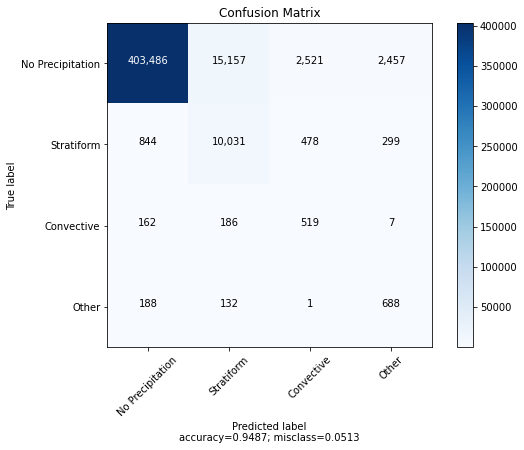

In [29]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

plot_confusion_matrix(cm           = conf_mat, 
                      normalize    = False,
                      target_names = ['No Precipitation', 'Stratiform', 'Convective', 'Other'],
                      title        = "Confusion Matrix")

## ROC Curves

In [30]:
from sklearn.metrics import roc_auc_score, roc_curve

def get_roc_curve(labels, y_true, y_pred):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = y_true[:, i]
            pred = y_pred[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals

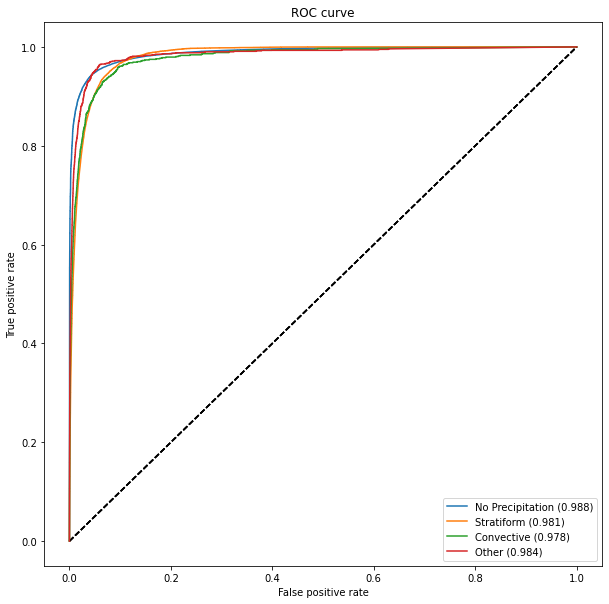

In [31]:
auc_rocs = get_roc_curve(['No Precipitation', 'Stratiform', 'Convective', 'Other'], y_test, y_pred_probs)

21


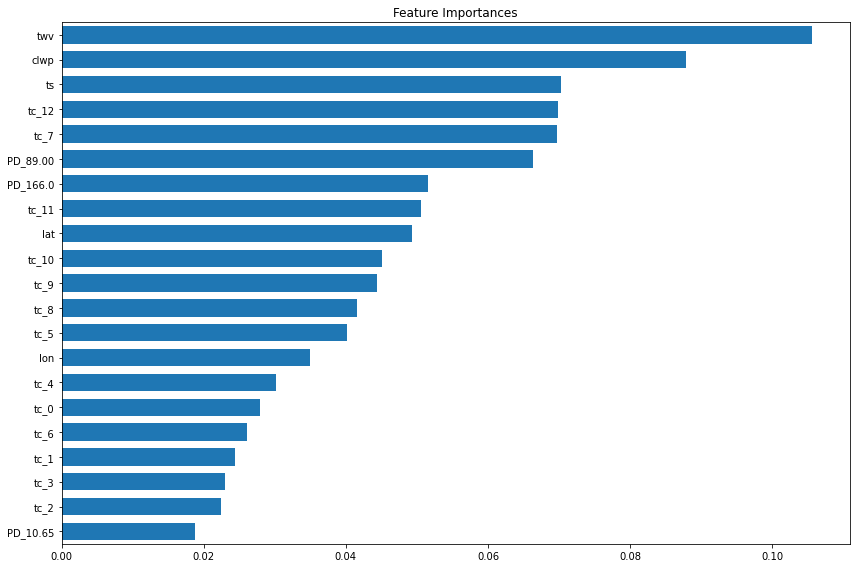

In [32]:
feature_names = np.array(['lat', 'lon',	'ts',	'clwp',	'twv', 'PD_10.65',	'PD_89.00',	'PD_166.0', 'tc_0', 'tc_1',	'tc_2', 'tc_3', 'tc_4',	'tc_5',	'tc_6',	'tc_7',	'tc_8',	'tc_9',	'tc_10', 'tc_11', 'tc_12'])
print(len(feature_names))
tree_importance_sorted_idx = np.argsort(rfc.feature_importances_)
tree_indices = np.arange(0, len(rfc.feature_importances_)) + 0.5
fig, (ax1) = plt.subplots(1, 1, figsize=(12, 8))
ax1.barh(tree_indices,
         rfc.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(feature_names[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(rfc.feature_importances_)))
plt.title('Feature Importances')
fig.tight_layout()
plt.show()

# Make Predictions (Squall Line case)

## Read and Prepare Data (20170606)

In [33]:
FILE_PATH = BASE_DIR + 'colloc_Precipflag_DPR_GMI_20170606.sav'
data = scipy.io.readsav(FILE_PATH, verbose=1)
for var, arr in data.items():
  print(f"{var}: {arr.shape}")

--------------------------------------------------
Date: Fri Jun 26 14:43:54 2020
User: jgong
Host: gs613-cirrus.ndc.nasa.gov
--------------------------------------------------
Format: 12
Architecture: x86_64
Operating System: linux
IDL Version: 8.7.3
--------------------------------------------------
Successfully read 14 records of which:
 - 11 are of type VARIABLE
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - tc [<class 'numpy.ndarray'>]
 - latc [<class 'numpy.ndarray'>]
 - lonc [<class 'numpy.ndarray'>]
 - utc [<class 'numpy.ndarray'>]
 - emis [<class 'numpy.ndarray'>]
 - emis_std [<class 'numpy.ndarray'>]
 - ts [<class 'numpy.ndarray'>]
 - clwp [<class 'numpy.ndarray'>]
 - twv [<class 'numpy.ndarray'>]
 - tysfc [<class 'numpy.ndarray'>]
 - pflag [<class 'numpy.ndarray'>]
--------------------------------------------------
tc: (44425, 221, 13)
latc: (44425, 221)
lonc: (44425, 221)
utc: (44425,)
emis: (44

In [34]:
# calculate polarization differences (PD)
def add_to_PD(freq, ind1, ind2, data):
  PD[freq] = data['tc'][:, :, ind1] - data['tc'][:, :, ind2]

PD = {}
add_to_PD('10.65', 0, 1, data)
add_to_PD('18.70', 2, 3, data)
add_to_PD('36.50', 5, 6, data)
add_to_PD('89.00', 7, 8, data)
add_to_PD('166.0', 9, 10, data)
print(PD.keys())

dict_keys(['10.65', '18.70', '36.50', '89.00', '166.0'])


In [35]:
def create_pred_df(lat_bounds, lon_bounds, epsilon=0.0):
  col_names = ['lat', 'lon', 'ts', 'clwp', 'twv', 'PD_10.65', 'PD_89.00', 'PD_166.0'] + [f'tc_{i}' for i in range(data['tc'].shape[2])]
  data_df = pd.DataFrame(columns=col_names)
  y_df = pd.DataFrame(columns=['pflag'])
  counter = 0
  for idx in np.ndindex(data['latc'].shape):
    if (lat_bounds[0] - epsilon <= data['latc'][idx] <= lat_bounds[1] + epsilon) and (lon_bounds[0] - epsilon <= data['lonc'][idx] <= lon_bounds[1] + epsilon):
      data_dict = {}
      data_dict['lat'] = data['latc'][idx]
      data_dict['lon'] = data['lonc'][idx]
      data_dict['ts'] = data['ts'][idx]
      data_dict['clwp'] = data['clwp'][idx]
      data_dict['twv'] = data['twv'][idx]
      data_dict['PD_10.65'] = PD['10.65'][idx]
      data_dict['PD_89.00'] = PD['89.00'][idx]
      data_dict['PD_166.0'] = PD['166.0'][idx]

      for i in range(data['tc'].shape[2]):
        data_dict[f'tc_{i}'] = data['tc'][idx][i]
      
      data_df = data_df.append(data_dict, ignore_index=True)
      y_df = y_df.append({'pflag': data['pflag'][idx]}, ignore_index=True)
      counter += 1
  print(counter)
  return data_df, y_df

In [36]:
latitude_bounds = [14.2, 18.0]
longitude_bounds = [-5.0, -2.1]

In [37]:
X_df, y_df = create_pred_df(latitude_bounds, longitude_bounds, epsilon=5.0)
del data

30537


In [38]:
print(X_df.shape)
print(y_df.shape)
y_df = y_df[(~np.isnan(X_df['twv']))]
X_df = X_df[(~np.isnan(X_df['twv']))]

(30537, 21)
(30537, 1)


In [39]:
X_df.head()

,lat,lon,ts,clwp,twv,PD_10.65,PD_89.00,PD_166.0,tc_0,tc_1,tc_2,tc_3,tc_4,tc_5,tc_6,tc_7,tc_8,tc_9,tc_10,tc_11,tc_12
0,9.245695,-8.154333,295.700745,0.030067,42.947613,4.769989,0.500000,-1.110016,280.429993,275.660004,281.179993,279.079987,284.190002,280.160004,279.119995,287.119995,286.619995,281.959991,283.070007,262.329987,273.390015
1,9.201105,-8.162495,295.606171,0.030496,43.775436,4.299988,0.609985,-1.599976,279.609985,275.309998,279.760010,277.609985,284.429993,280.559998,278.170013,286.649994,286.040009,281.730011,283.329987,262.679993,272.549988
2,9.356602,-8.110878,296.003632,0.028761,40.843277,1.380005,-0.079987,1.739990,278.779999,277.399994,280.299988,279.140015,284.089996,280.859985,278.760010,286.890015,286.970001,284.609985,282.869995,263.019989,273.160004
3,9.356602,-8.110878,295.909607,0.029196,38.724518,5.550018,0.330017,1.739990,281.420013,275.869995,281.100006,278.410004,283.480011,281.029999,279.470001,286.690002,286.359985,284.609985,282.869995,263.019989,273.160004
4,9.267323,-8.126661,295.817108,0.029630,42.280800,3.300018,0.779999,0.000000,279.660004,276.359985,279.899994,278.959991,283.369995,279.890015,279.450012,286.690002,285.910004,282.579987,282.579987,263.359985,273.220001


In [40]:
y_df.head()

,pflag
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


## Plot Squall Line Case

In [78]:
lat, lon, counts = [], [], []
rfc.verbose = False
X_scaled = scaler.transform(X_df)
print("X: ", sum(np.isnan(X_scaled)))  # should be all zeros
y_pred = np.argmax(rfc.predict(X_scaled), axis=1)
y_probs = rfc.predict_proba(X_scaled)
y_pred_probs = np.transpose(np.array([y_probs[0][:, 1], y_probs[1][:, 1], y_probs[2][:, 1], y_probs[3][:, 1]]))
y_pred_probs = np.max(y_pred_probs, axis=1)

row_set = set()
for r, _ in np.ndindex(X_scaled.shape):
  if r in row_set:
    continue
  # if y_pred_probs[r] < 0.75:
  #   continue
  row_set.add(r)
  lat.append(X_df.iloc[r, 0])
  lon.append(X_df.iloc[r, 1])
  counts.append(y_pred[r].astype(float))

  # y_val = y_df.iloc[r, 0]
  # if np.isnan(y_val):
  #   counts.append(y_pred[r].astype(float))
  # else:
  #   counts.append(y_val)

X:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [79]:
print(len(lat))
print(len(lon))
print(len(counts))

30535
30535
30535


Saved to /content/drive/My Drive/data/NASA_2020/plots/Precip. Type Filled.png


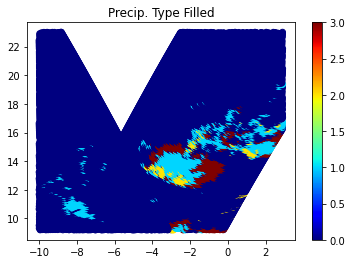

In [80]:
title = "Precip. Type Filled"
plt.scatter(lon, lat, c=counts, cmap=plt.get_cmap("jet"))
plt.colorbar()
plt.title(title)
### SAVE HEATMAP ###############################
save_path = BASE_DIR + "plots/"
if not os.path.exists(save_path):
  os.mkdir(save_path)
print('Saved to', save_path + f"{title}.png")
plt.savefig(save_path + f"{title}.png")
################################################
plt.show()